# Andiamo a caricare il file con la resa

In [87]:
import rasterio
from matplotlib import pyplot as plt
import pickle
import numpy as np
from tsmoothie.smoother import LowessSmoother
from mpl_toolkits.mplot3d import axes3d
from datetime import datetime
import skfda
from skfda.representation.interpolation import SplineInterpolation
from sklearn.preprocessing import normalize

(56, 72)
[[    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.   7282.1  6796.   6806.5  8419.6  7417.9  7409.8  7554.9
   5271.1  6534.1  7941.2  7744.3  7762.2  7638.9  5898.   6455.4  7102.3
   7504.7  7910.1  7522.8  5949.3    99.9  3089.9  4058.4     0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
   6142.5  6650.7  6426.   9171.4  876

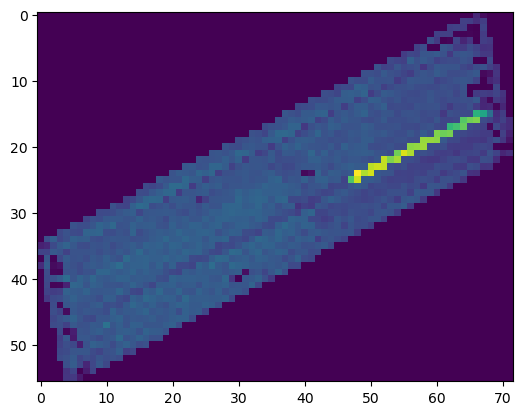

In [88]:
resa3 = rasterio.open(r'OUTPUT.tif')
print(resa3.shape)
plt.imshow(resa3.read(1))
resa3 = resa3.read(1)
print(resa3[10:20])

In [89]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)

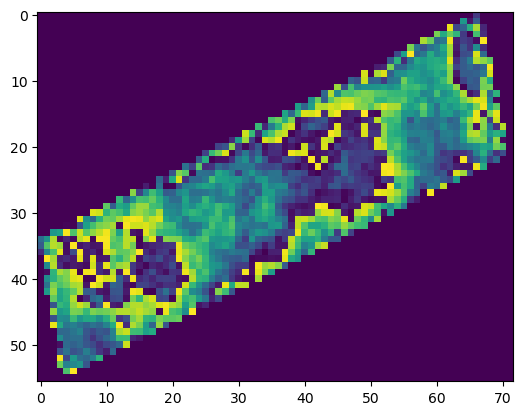

In [90]:
campo3 = rasterio.open(r'campo3.tiff')
plt.imshow(campo3.read(1))

# Procediamo ad aggiungere i valori della resa all'immagine

(57, 12, 56, 72)


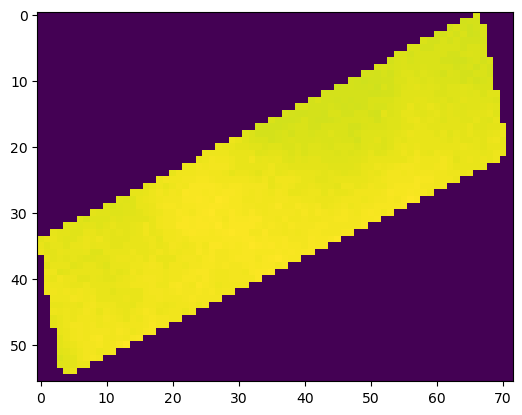

In [91]:
with open('campo3_bande.pickle', 'rb') as handle:
    campo3 = pickle.load(handle)
print(campo3.shape)
plt.imshow(campo3[4][2])

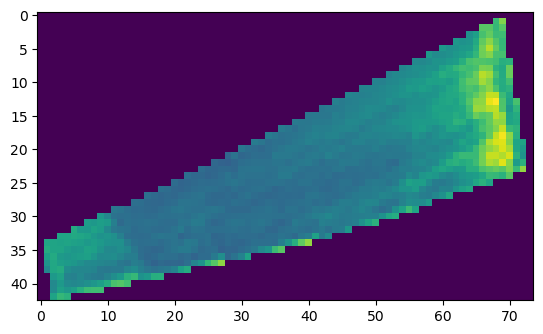

In [92]:
with open('campo4_bande.pickle', 'rb') as handle:
    campo4 = pickle.load(handle)
plt.imshow(campo4[30][2])

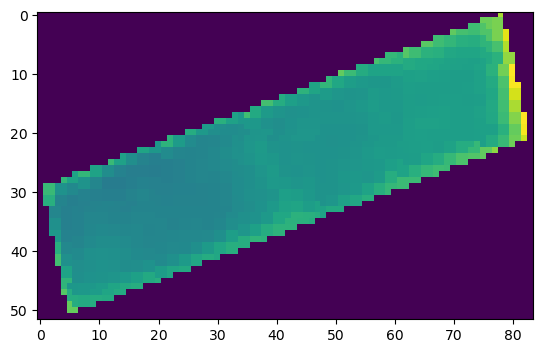

In [93]:
with open('campo6_bande.pickle', 'rb') as handle:
    campo6 = pickle.load(handle)
plt.imshow(campo6[40][10])

(1579,)


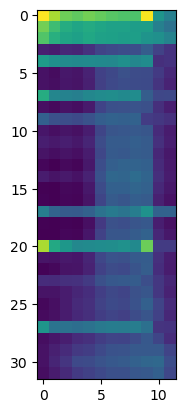

In [94]:
newImage3 = []
newResa3 = []
for x in range(0, campo3.shape[2]):
    for y in range(0,campo3.shape[3]):
        if(np.sum(campo3[:,:,x,y] != 0)):
            newImage3.append(campo3[18:50,:,x,y]/12000) # Abbiamo preso l'intervallo consigliato dal professore
            newResa3.append(resa3[x,y])
newResa3 = np.array(newResa3)
print(newResa3.shape)
plt.imshow(newImage3[10])

# Mi salvo l'ordine delle rese che ssegue l'ordine dei pixel

with open('newResa3.pickle', 'wb') as handle:
    pickle.dump(newResa3, handle, protocol=pickle.HIGHEST_PROTOCOL)

(1579, 32, 12)


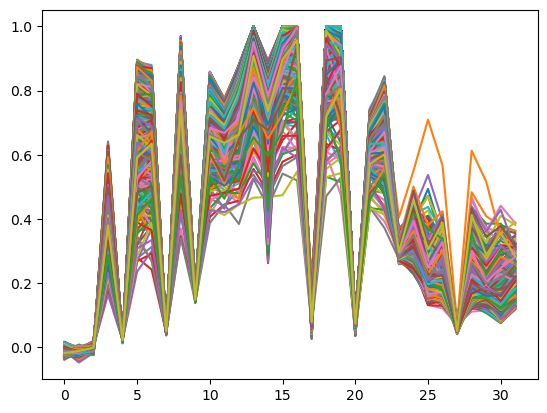

In [95]:
print(np.array(newImage3).shape)
for a in range(0,np.array(newImage3).shape[0]):
    plt.plot((newImage3[a][:,7]-newImage3[a][:,3])/(newImage3[a][:,7]+newImage3[a][:,3]))

# Andiamo a eseguire un' operazione di smoothing

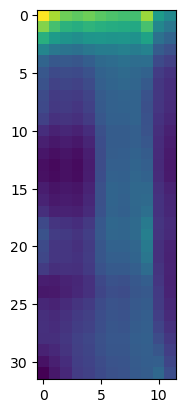

In [96]:
imageSmooth = newImage3

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.2, iterations=1)

for x in range(len(newImage3)):
    for banda in range(0,campo3.shape[1]):
        imageSmooth[x][:,banda] = smoother.smooth(newImage3[x][:,banda]).smooth_data[0]

plt.imshow(imageSmooth[10])


(1579, 32, 12)


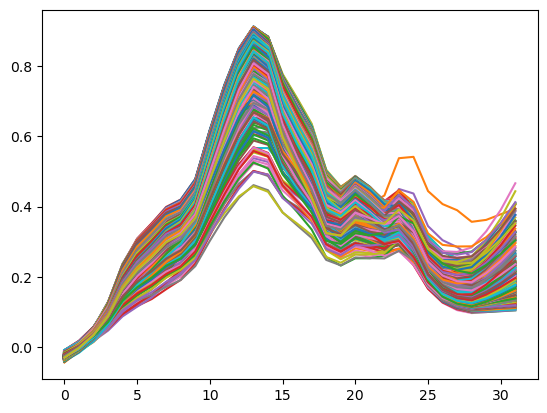

In [97]:
print(np.array(imageSmooth).shape)
for a in range(0,np.array(imageSmooth).shape[0]):
    plt.plot((imageSmooth[a][:,7]-imageSmooth[a][:,3])/(imageSmooth[a][:,7]+imageSmooth[a][:,3]))

# Interpolazione

In [98]:
date = ['2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
days = []
zeroDay = datetime.strptime("2017-01-01","%Y-%m-%d")
date_cut = date[18:50]
for a in date_cut:
    days.append((datetime.strptime(a,"%Y-%m-%d")-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves

inter = skfda.FDataGrid(
    data_matrix=np.transpose(imageSmooth), #imageSmooth[0]
    grid_points=grid_points,
)
 
#inter.plot()

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]


In [99]:
inter.interpolation = SplineInterpolation(
    interpolation_order= 3
)
#inter.plot()

(12, 30, 1579)


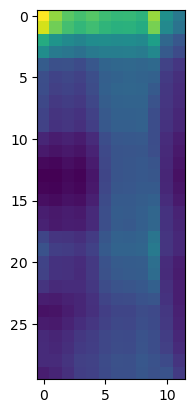

In [100]:
step = 5
test = inter.interpolation._evaluate(inter,range(43,193,step))
#newInter = inter.interpolation._evaluate(inter,range(43,193,5))[:,:,0]
print(test[:,:,:].shape)
plt.imshow(np.transpose(test[:,:,700]))

# Array di pixel ( altro metodo )

In [101]:
allPixel = []

for a in range(0,np.array(imageSmooth).shape[0]):
    inter.data_matrix = np.transpose(imageSmooth[a])
    inter.interpolation = SplineInterpolation(interpolation_order= 3)
    allPixel.append(inter.interpolation._evaluate(inter,range(43,193,5))[:,:,0])

(1579, 12, 30)


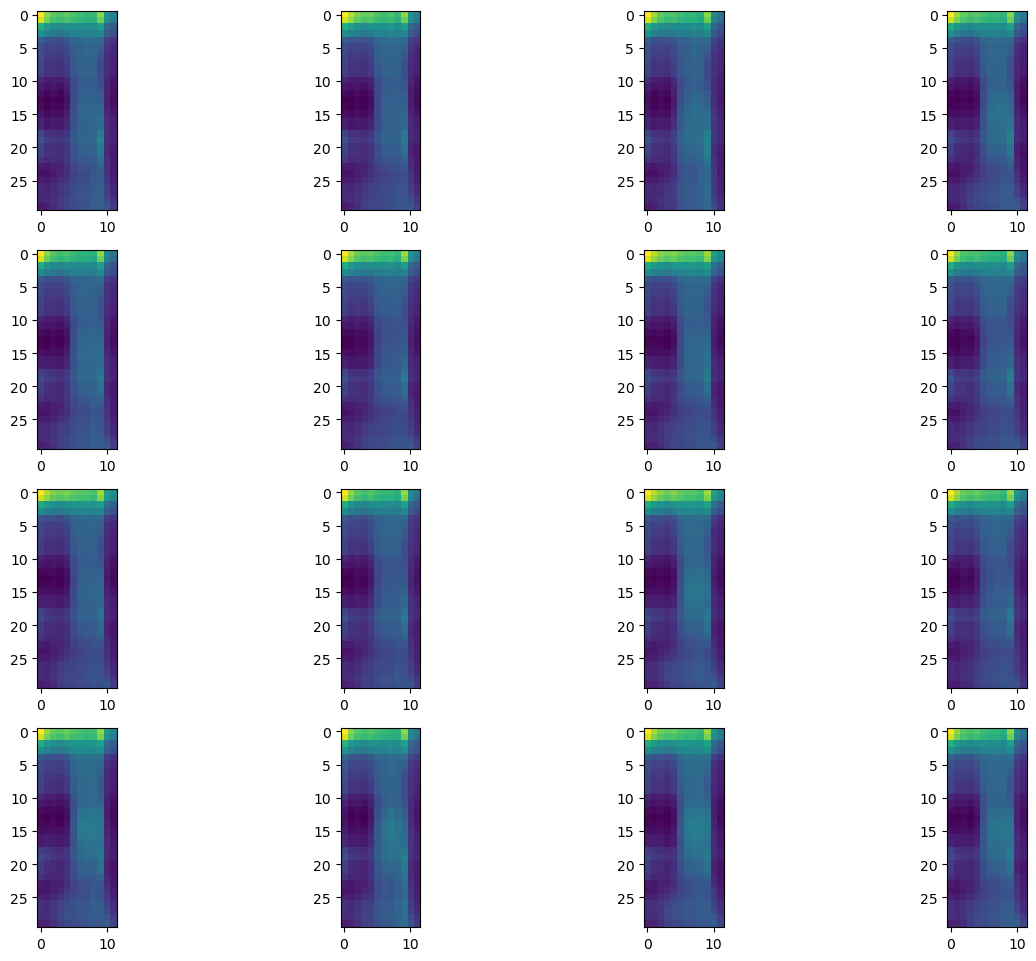

In [102]:
allPixel = np.array(allPixel)
print(allPixel.shape)

#fig = plt.figure(figsize=(10,9))
#f, axarr = plt.subplots(15,1) 
'''plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

for a in range(0,4):
    plt.subplot(1, 4, a+1)
    plt.imshow(np.transpose(allPixel[(a*150),:,:]))
    #axarr[a].imshow()
plt.show()'''



fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(allPixel[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Test per aumentare le piccole differenze 

In [103]:
Prüfung = allPixel
Prüfung = (Prüfung*100)-100
Prüfung = (Prüfung- np.min(Prüfung))/np.ptp(Prüfung)

(1579, 12, 30)


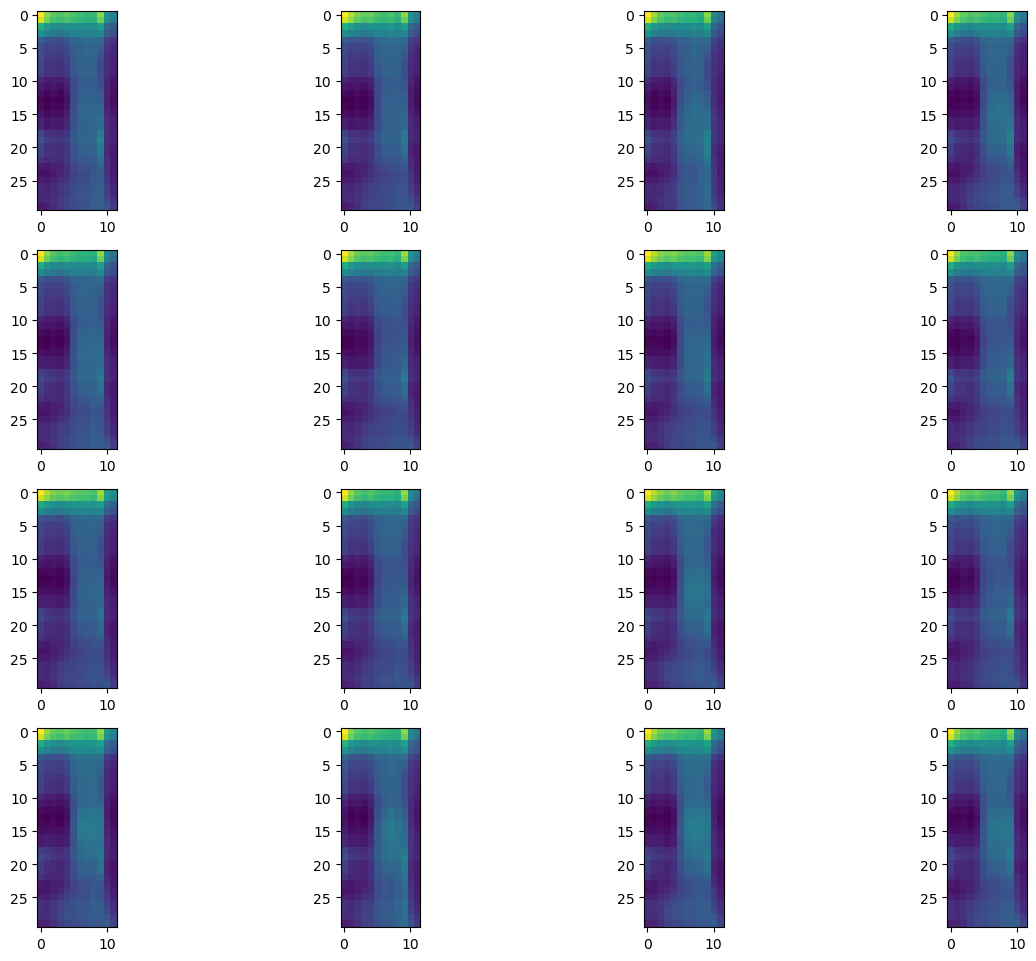

In [104]:
print(Prüfung.shape)
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(Prüfung[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [105]:
print(Prüfung[10:20,7,15])

[0.28994112 0.30712797 0.31768735 0.31706911 0.30515232 0.30230499
 0.30124705 0.29240774 0.29453101 0.28977867]


In [106]:
print(allPixel[10:20,7,15])

with open('AllPixelBand3.pickle', 'wb') as handle:
    pickle.dump(allPixel, handle, protocol=pickle.HIGHEST_PROTOCOL)

[0.34315099 0.36242307 0.37426358 0.37357034 0.36020772 0.35701494
 0.35582864 0.34591688 0.34829777 0.34296884]
